# Questions 

# Import, options

In [2]:
import numpy, seaborn, pandas, gseapy
import scipy.stats as stats
import matplotlib, matplotlib.pyplot as plt
import statsmodels.api

from gseapy import barplot, dotplot
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import fcluster
from scipy.stats import linregress

C:\Users\kja11\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
matplotlib.rcParams.update({'svg.fonttype' : 'none'})
#'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20,'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',                            'figure.figsize':(8, 5), 

In [4]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# Data Download

In [5]:
# Values are Protein abundance by TMT reporter ion intensity
# Stats are ANOVA
# Peptides number = 15487

In [6]:
#data Proteomics
df = pandas.read_csv(file_directory+'1) input/proteomics/Pilot_ProteomicsData.csv', 
                     sep = ',', index_col = 'Gene')
df = df.iloc[:,4:-3]

df.columns = df.columns.str.split('_').str[0]
df_with_tripl = df.copy()
df = df.groupby(axis=1, level=0).median()
df = df[['Ctrl', '3h', '6h', '9h', '12h', '16h']]

print(df.shape, '\n')
df.head(3)

(2405, 6) 



C:\Users\kja11\AppData\Local\Temp\ipykernel_17296\3986874491.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(axis=1, level=0).median()


,Ctrl,3h,6h,9h,12h,16h
Gene,,,,,,
DIS3,92.9,96.6,91.6,105.8,103.0,115.5
LARP1,103.3,106.6,103.5,99.1,95.3,93.2
ACTB,100.9,107.1,102.3,94.4,93.9,100.4


In [7]:
df_linregress = pandas.read_csv(file_directory+'3) output/Proteomics/df_linregress_noCTL.csv', 
                     sep = ',', index_col = 'Gene')

df_linregress.head()

,slope,intercept,rvalue,pvalue,adj_pvalue
Gene,,,,,
DIS3,1.515694,87.275616,0.805491,0.000290,0.040984
LARP1,-1.009533,108.867704,-0.877613,0.000017,0.019899
ACTB,-0.490661,104.354086,-0.435866,0.104359,0.316498
PSMA2,-0.902140,108.073022,-0.692949,0.004183,0.087465
PRRC1,-0.928729,108.084306,-0.461475,0.083357,0.276843


In [8]:
# List of filtered proteins
proteomics_path = file_directory + "3) output/Proteomics/"

with open(proteomics_path+'Early_res_CoeffVar_proteins.txt') as f:
    Early_res_CoeffVar_proteins = f.read().splitlines()
    
print("Early_res_CoeffVar_proteins:", len(Early_res_CoeffVar_proteins))

with open(proteomics_path+'high_Rvalue_linregress_proteins.txt') as f:
    high_Rvalue_linregress_proteins = f.read().splitlines()
    
print("high_Rvalue_linregress_proteins:", len(high_Rvalue_linregress_proteins))


Early_res_CoeffVar_proteins: 179
high_Rvalue_linregress_proteins: 302


# Data transformation

## To Zscore 

In [9]:
# Convert to Z_score
df_zscore = stats.zscore(df, axis = 0)
df_zscore.head(2)

,Ctrl,3h,6h,9h,12h,16h
Gene,,,,,,
DIS3,-1.092419,-0.367305,-1.569021,0.917407,0.601398,2.127101
LARP1,0.748607,1.131631,0.843713,-0.246745,-0.859439,-1.056857


# Methods

## Find proteins with mirror expression of SMYD5

In [10]:
import warnings
warnings.filterwarnings('ignore')

Select the proteins with 
- high variation from 0 to 3h. And from these selection, find the proteins with rvalue < -0.8 =  mirror expression.
- positive slope from 3h to 16h. And why not Rvalue too

In [11]:
df_linregress[(df_linregress.index == 'SMYD5') | (df_linregress.index == 'RING1')]

,slope,intercept,rvalue,pvalue,adj_pvalue
Gene,,,,,
RING1,1.412581,88.190921,0.731863,0.001925,0.080206
SMYD5,-2.081712,118.285084,-0.727675,0.002105,0.080206


In [12]:
# Extract the SMYD5 expression pattern
smyd5_expression = df.loc['SMYD5']
smyd5_expression

Ctrl    101.6
3h      119.4
6h      101.0
9h      100.5
12h      96.7
16h      81.2
Name: SMYD5, dtype: float64

In [13]:
# select proteins with positive slope to have mirror
mirror_slop_proteins = df_linregress[df_linregress.index.isin(high_Rvalue_linregress_proteins)]
mirror_slop_proteins = df_linregress[df_linregress.slope > 1].index
print(len(mirror_slop_proteins))

# select proteins with high variation at 3h & Calculate Rvalue with SMYD5, and select high negative ones
mirror_CV_proteins = df[df.index.isin(Early_res_CoeffVar_proteins)]
mirror_CV_proteins = mirror_CV_proteins.index
print(len(mirror_CV_proteins))

248
179


In [14]:
# Now, select mirror proteins
set1 = set(mirror_slop_proteins)
set2 = set(mirror_CV_proteins)

mirror_slop_CV = set1.intersection(set2)
len(mirror_slop_CV)

46

In [15]:
# create df with them
mirror_proteins_df = df[df.index.isin(mirror_slop_CV)]

# do correlation with SMYD5 results to select the one with mirror expression = neg corr
correlations = mirror_proteins_df.T.corrwith(smyd5_expression)
neg_corr_proteins = correlations[correlations < -0.7].index
len(neg_corr_proteins)

24


proteins from 0 to 4 are: ['SLIT3', 'NUDT5', 'PM20D2', 'PPP1CC', 'SMYD5']



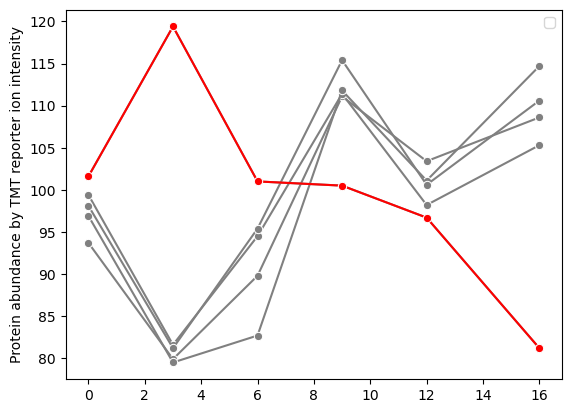


proteins from 4 to 8 are: ['EXOSC2', 'TIMM10B', 'LIN7A', 'IK', 'SMYD5']



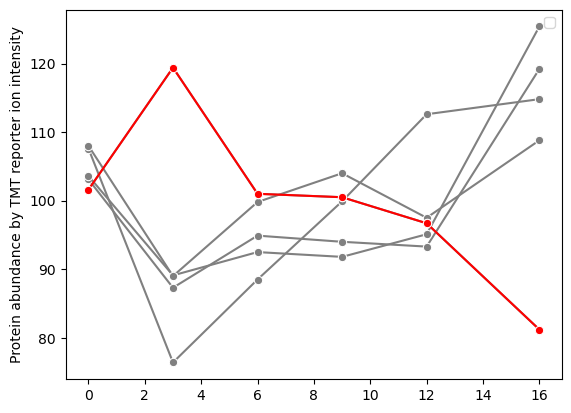


proteins from 8 to 12 are: ['SAMM50', 'VAMP2', 'LMAN2', 'SNRPB', 'SMYD5']



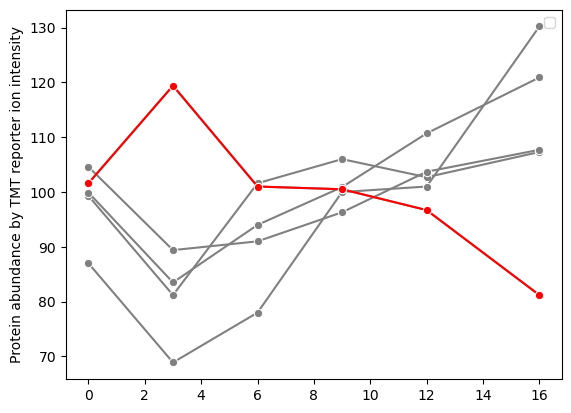


proteins from 12 to 16 are: ['GCSH', 'PPAN', 'SCFD1', 'ZNF512', 'SMYD5']



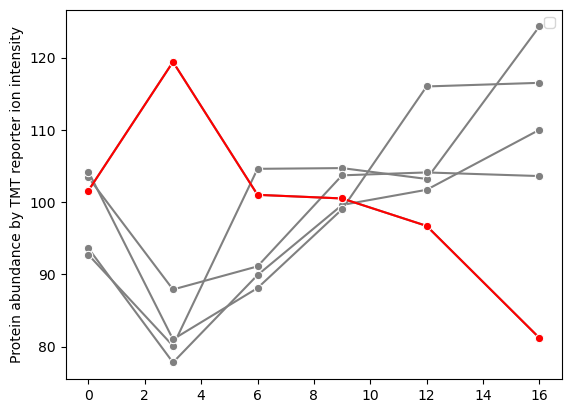


proteins from 16 to 20 are: ['ETFDH', 'S100A10', 'ALDH2', 'H3-3A', 'SMYD5']



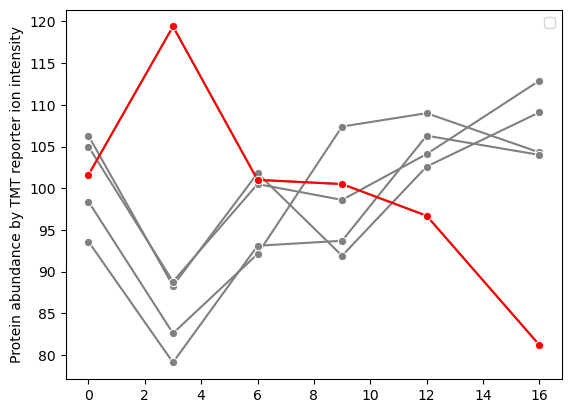


proteins from 20 to 24 are: ['SUZ12', 'MRPL23', 'MAPK4', 'SELENOK', 'SMYD5']



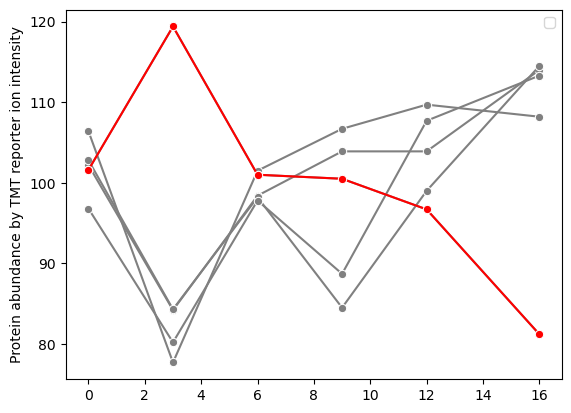

In [23]:
# Select the targets
df_mirror =  df[ (df.index.isin(neg_corr_proteins)) ]
df_mirror.loc['SMYD5'] = smyd5_expression
df_mirror = df_mirror.reset_index()

# Select and plot 5 by 5 and have good visualization
n1s = 0, 4, 8, 12, 16, 20
n2s = 4, 8, 12, 16, 20, 24

for i in range(len(n1s)):
    n1 = n1s[i]
    n2 = n2s[i]
    
    data = df_mirror.iloc[list(range(n1, n2)) + [-1]]
    print(f'\nproteins from {n1} to {n2} are: {list(data.Gene)}\n')  
    
    # From Wide to Long table
    data = data.melt(id_vars=["Gene"], var_name="conditions")
    
    #rename to have y as float
    data['conditions'].replace({'Ctrl': 0, '3h': 3, '6h': 6, 
                                      '9h': 9, '12h': 12, '16h': 16, }, inplace=True)
    
    
    data2 = data[data.Gene == 'SMYD5']
    
    seaborn.lineplot(data = data, x='conditions' , y='value', hue= "Gene",
                     marker='o', palette=['grey'], err_style="bars", errorbar=('se', 0.5))
    
    seaborn.lineplot(data = data2, x='conditions' , y='value', hue= "Gene",
                     marker='o', palette=['red'], err_style="bars", errorbar=('se', 0.5))
    
    plt.ylabel("Protein abundance by TMT reporter ion intensity")
    plt.xlabel("")
    plt.legend('')
    plt.show()
    plt.close()


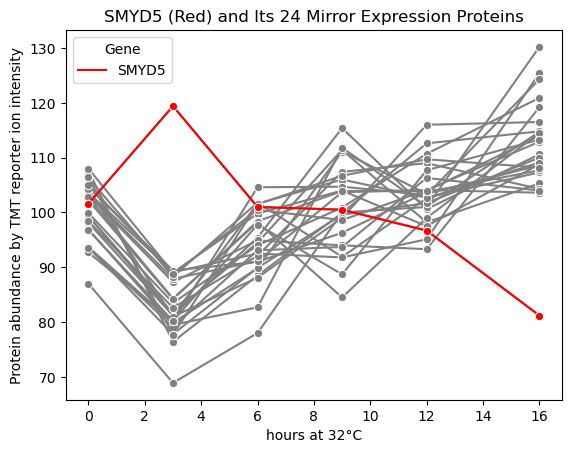

In [53]:
# Select the targets
df_mirror =  df[ (df.index.isin(neg_corr_proteins)) ]
df_mirror.loc['SMYD5'] = smyd5_expression
df_mirror = df_mirror.reset_index()

# From Wide to Long table
data = df_mirror.melt(id_vars=["Gene"], var_name="conditions")

#rename to have y as float
data['conditions'].replace({'Ctrl': 0, '3h': 3, '6h': 6, 
                                  '9h': 9, '12h': 12, '16h': 16, }, inplace=True)


data2 = data[data.Gene == 'SMYD5']

seaborn.lineplot(data = data, x='conditions' , y='value', hue= "Gene",
                 marker='o', palette=['grey'],  legend=None, err_style="bars", errorbar=('se', 0.5))

seaborn.lineplot(data = data2, x='conditions' , y='value', hue= "Gene",
                 marker='o', palette=['red'], err_style="bars", errorbar=('se', 0.5))

plt.title("SMYD5 (Red) and Its 24 Mirror Expression Proteins")
plt.ylabel("Protein abundance by TMT reporter ion intensity")
plt.xlabel("hours at 32°C")

plt.show()
plt.close()

In [35]:
list(df_mirror.iloc[:-1].Gene)

['SLIT3',
 'NUDT5',
 'PM20D2',
 'PPP1CC',
 'EXOSC2',
 'TIMM10B',
 'LIN7A',
 'IK',
 'SAMM50',
 'VAMP2',
 'LMAN2',
 'SNRPB',
 'GCSH',
 'PPAN',
 'SCFD1',
 'ZNF512',
 'ETFDH',
 'S100A10',
 'ALDH2',
 'H3-3A',
 'SUZ12',
 'MRPL23',
 'MAPK4',
 'SELENOK']

In [47]:
# names = gseapy.get_library_name(organism='Human')
# names

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [52]:
# Perform GO enrichment analysis using Enrichr
subgroup = list(df_mirror.iloc[:-1].Gene)
sub_label ='OvTime - Down regulated'

enr_TF = gseapy.enrichr(gene_list = subgroup,
                        gene_sets= ['ARCHS4_TFs_Coexp'],
                        organism='Human',
                        outdir='Enrichr_results',
                        cutoff=0.08)

# categorical scatterplot
colors = seaborn.hls_palette(3)
barplot(enr_TF.results,
        column="Adjusted P-value",
        group='Gene_set',
        size=10,
        top_term=5,
#         figsize=(3,5),
        title=f'SMYD5 mirror proteins',
        color=colors)

ValueError: Warning: No enrich terms when cutoff = 0.08

In [54]:
print("no ENRICHR significant")

no ENRICHR significant
